In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, Pendulum
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap

In [ ]:
def reconstruct_from_pendulum_observables(observable):
    if len(observable.shape) == 1:
        return observable[:2]
    else:
        return observable[:, :2]

def compute_pendulum_observables(x):    
    if len(x.shape) == 1:
        x = x.reshape((1, 1, x.shape[0]))
    elif len(x.shape) == 2:
        x = x.reshape((1, x.shape[0], x.shape[1]))
    
    thetas = np.expand_dims(x[:, :, 0], axis=-1)
    omegas = np.expand_dims(x[:, :, 1], axis=-1)
    sin_theta = np.sin(thetas)
    cos_theta = np.cos(thetas)
        
    observables = np.concatenate([
        thetas,
        omegas,
        sin_theta,
        cos_theta,
        sin_theta * omegas,
        cos_theta * omegas
    ], axis=-1)
    
    return observables.squeeze()

In [ ]:
xs = np.random.rand(100, 32, 2)
obs = compute_pendulum_observables(xs)
assert np.allclose(obs[:, :, :2], xs)

In [ ]:
# Test DMD method with known matrix
K = np.random.rand(3,3)
K = K.T @ K

N = 5
X = np.empty((N, 2, 3))
xs = np.random.rand(N, 3)
ys = (K @ xs.T).T

pairs = np.stack([xs, ys], axis=0)
pairs = einops.rearrange(pairs, 'p n x -> n p x')

A, B = generate_lstsq_matrices(pairs)

K_est = B @ np.linalg.pinv(A)
print("K estimated:\n", K_est)
print("K true:\n", K)

K estimated:
 [[0.99130756 0.80503791 0.40339256]
 [0.80503791 1.09226934 0.84619949]
 [0.40339256 0.84619949 0.77851992]]
K true:
 [[0.99130756 0.80503791 0.40339256]
 [0.80503791 1.09226934 0.84619949]
 [0.40339256 0.84619949 0.77851992]]


Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 18916.44it/s]


Text(0, 0.5, 'State')

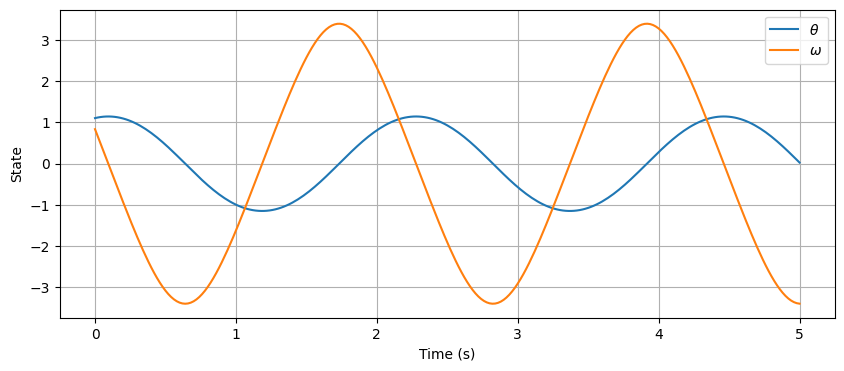

In [ ]:
# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81))

N = 100
theta0 = np.random.uniform(0, 2*np.pi, (N, 1))
omega0 = np.random.uniform(-5.0, 5.0, (N, 1))
x0 = np.hstack((theta0, omega0))

ts, xhist, _ = simulate_batch(
    sys=pendulum,
    tf=5.0,
    dt=0.02,
    u=lambda t, xs: np.zeros((N, 1)),
    x0=x0
)

# Visualize a random trajectory
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ts, xhist[0, :, 0], label=r'$\theta$')
ax.plot(ts, xhist[0, :, 1], label=r'$\omega$')
ax.legend()
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('State')

In [ ]:
phis_hist = compute_pendulum_observables(xhist)
print("Shape of observables:", phis_hist.shape)

phis_curr = phis_hist[:, :-1, :]
phis_next = phis_hist[:, 1:, :]

phis_curr = einops.rearrange(phis_curr, 'n t o -> (n t) o').T
phis_next = einops.rearrange(phis_next, 'n t o -> (n t) o').T

K = phis_next @ np.linalg.pinv(phis_curr)
print("# of observables:", phis_hist.shape[-1])

Shape of observables: (100, 251, 6)
# of observables: 6
K condition number: 1.3562880160318447


In [ ]:
# Take the simulated systems and roll it out with the learned Koopman operator
x0 = np.array([
    np.random.uniform(0, 2*np.pi),
    np.random.uniform(-10.0, 10.0)
])

ts, xhist, _ = simulate(
    sys=pendulum,
    tf=5.0,
    dt=0.02,
    u=lambda t, xs: np.zeros(1),
    x0=x0
)

xhist_pred = np.empty_like(xhist)
xhist_pred[0] = x0

for i in range(len(ts) - 1):
    x_next = reconstruct_from_pendulum_observables(K @ compute_pendulum_observables(xhist[i]))
    xhist_pred[i+1] = x_next

Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 14657.61it/s]


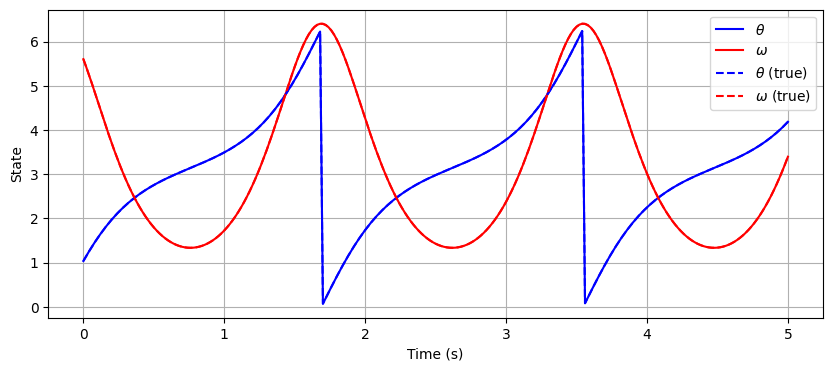

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ts, angle_wrap(xhist_pred[:, 0], "0:2pi"), label=r'$\theta$', c='blue')
ax.plot(ts, xhist_pred[:, 1], label=r'$\omega$', c='red')

ax.plot(ts, angle_wrap(xhist[:, 0], "0:2pi"), '--', label=r'$\theta$ (true)', c='blue')
ax.plot(ts, xhist[:, 1], '--', label=r'$\omega$ (true)', c='red')

ax.legend()
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('State')
plt.show()